In [18]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


-----
-----
## $f_1(x_1, x_2, x_3, x_4)$

##### $f_1(x_1, x_2, x_3, x_4) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

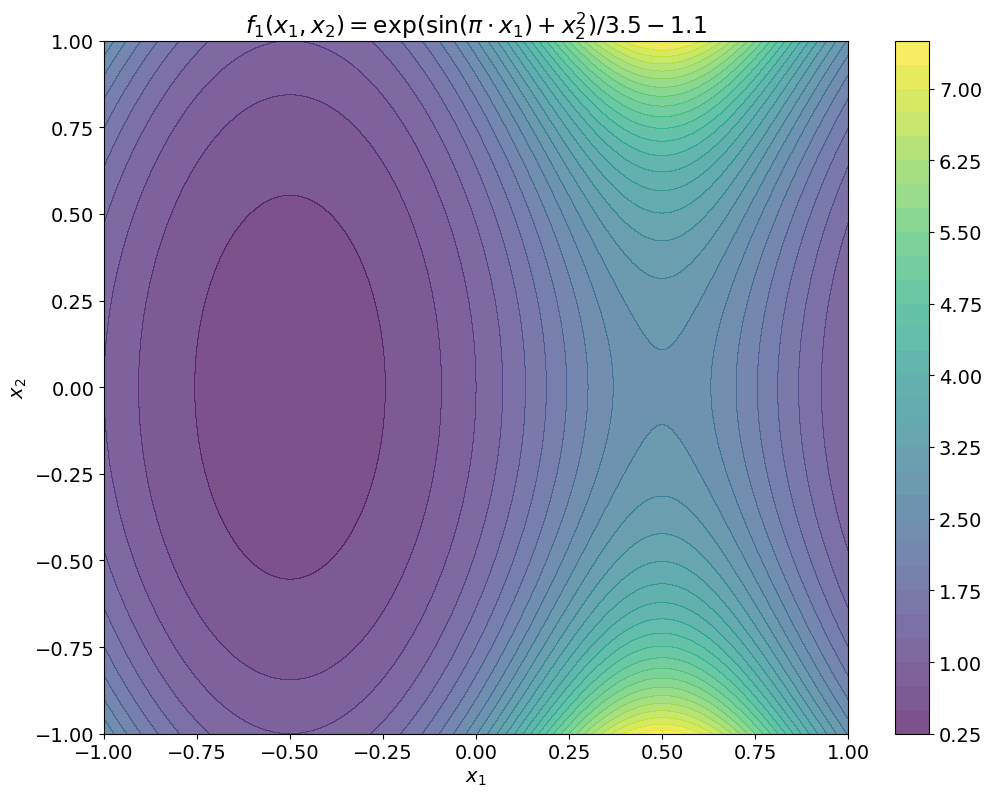

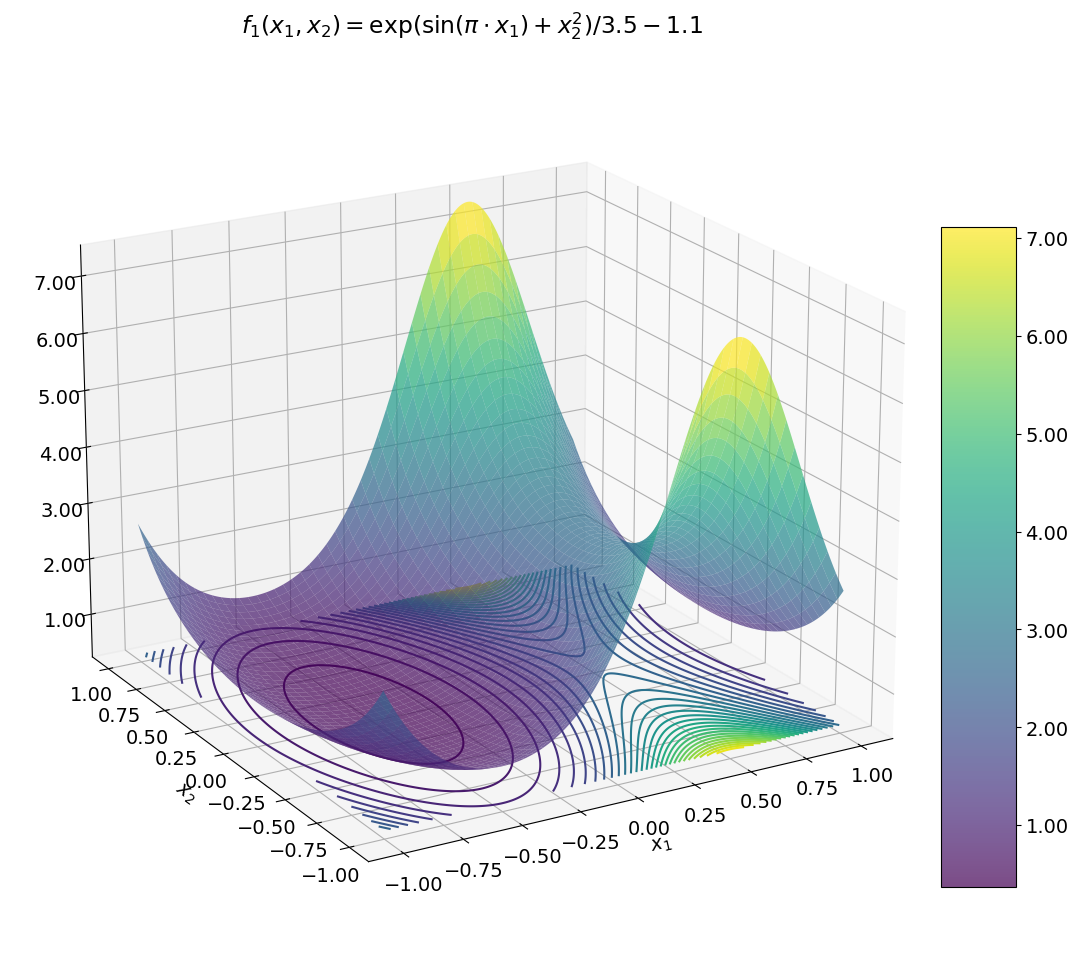

In [19]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=4, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 246


| train_loss: 3.60e-02 | test_loss: 4.73e-02 | reg: 1.12e+02 | : 100%|█| 100/100 [00:03<00:00, 26.48


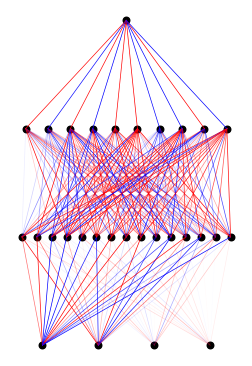

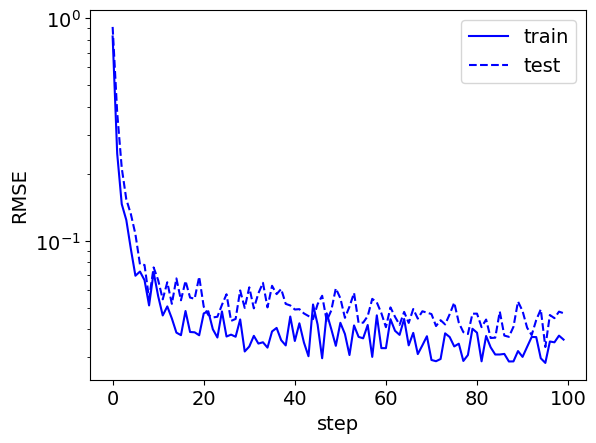

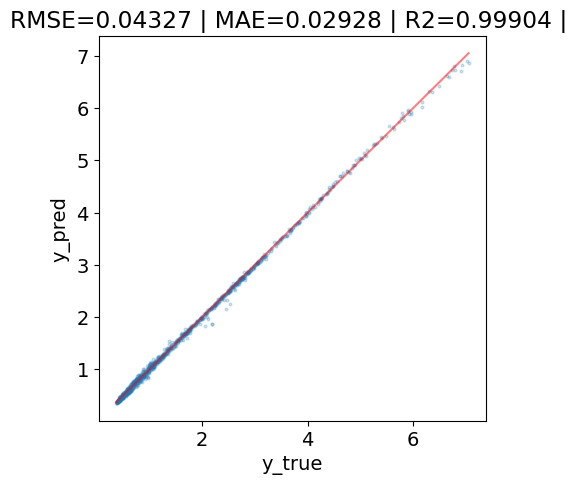

In [21]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 7.97e-03 | test_loss: 7.84e-03 | reg: 1.18e+01 | : 100%|█| 100/100 [00:30<00:00,  3.23


saving model version 0.1


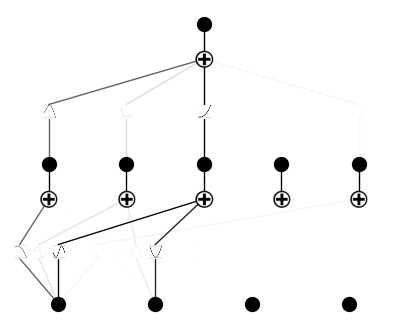

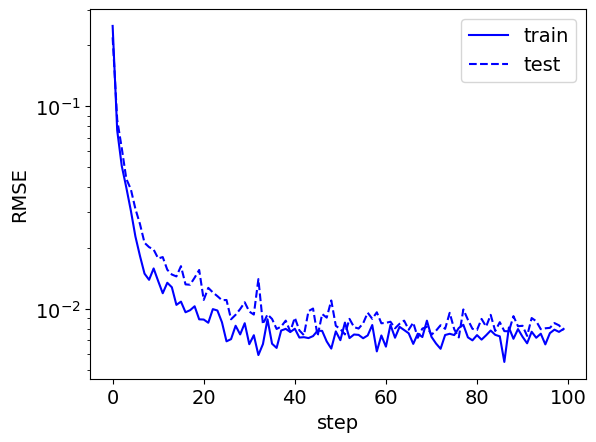

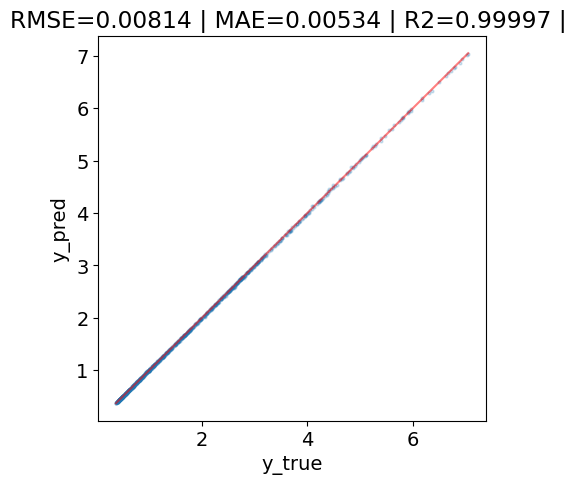

In [23]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 2.93e-01 | test_loss: 3.47e-01 | reg: 2.12e+01 | : 100%|█| 150/150 [00:54<00:00,  2.78


saving model version 0.1


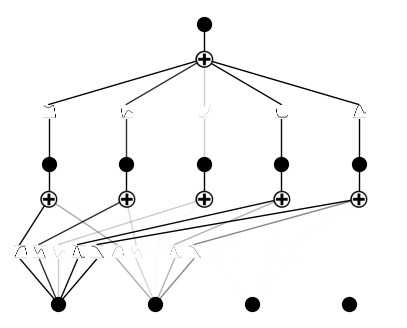

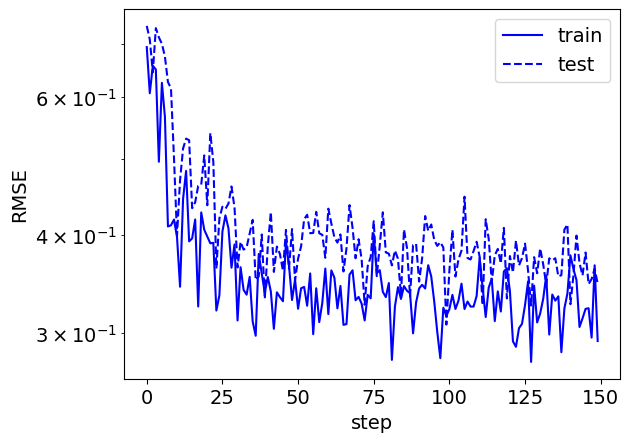

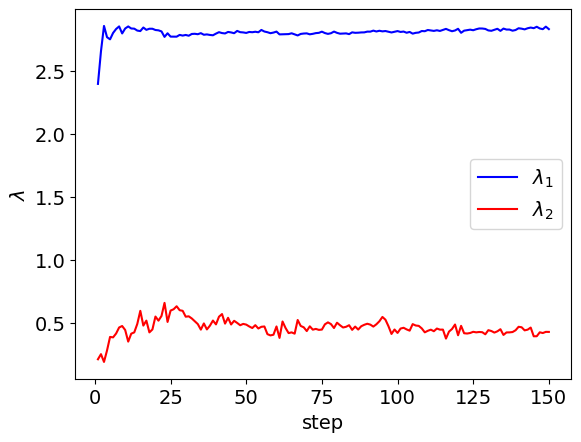

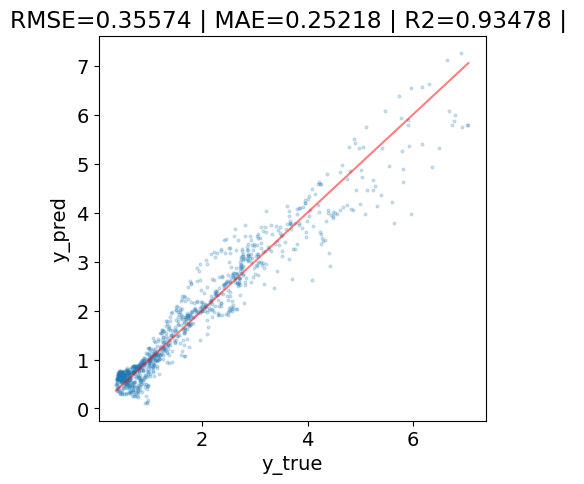

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.8325e+00,  4.2654e-01,  1.1600e-02, -5.2090e-04],
       requires_grad=True)


In [24]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:30, 22.16it/s]                         


module of Input importance:


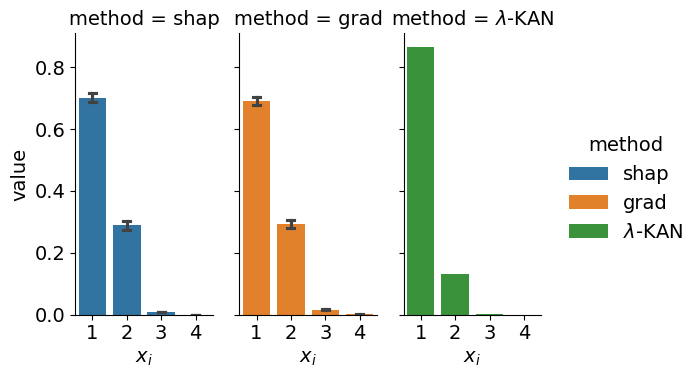

Input importance:


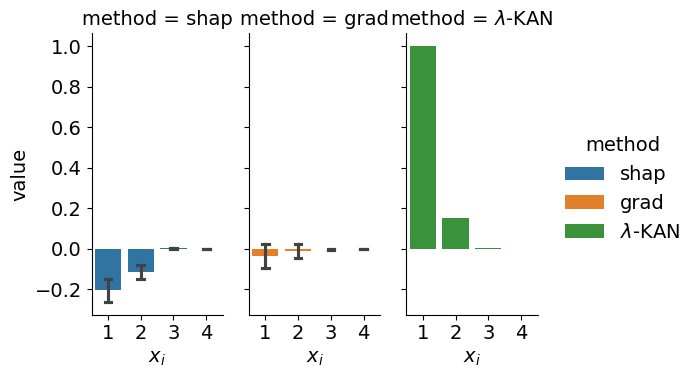

In [25]:
importance_analyse_lmdKAN(model, dataset)

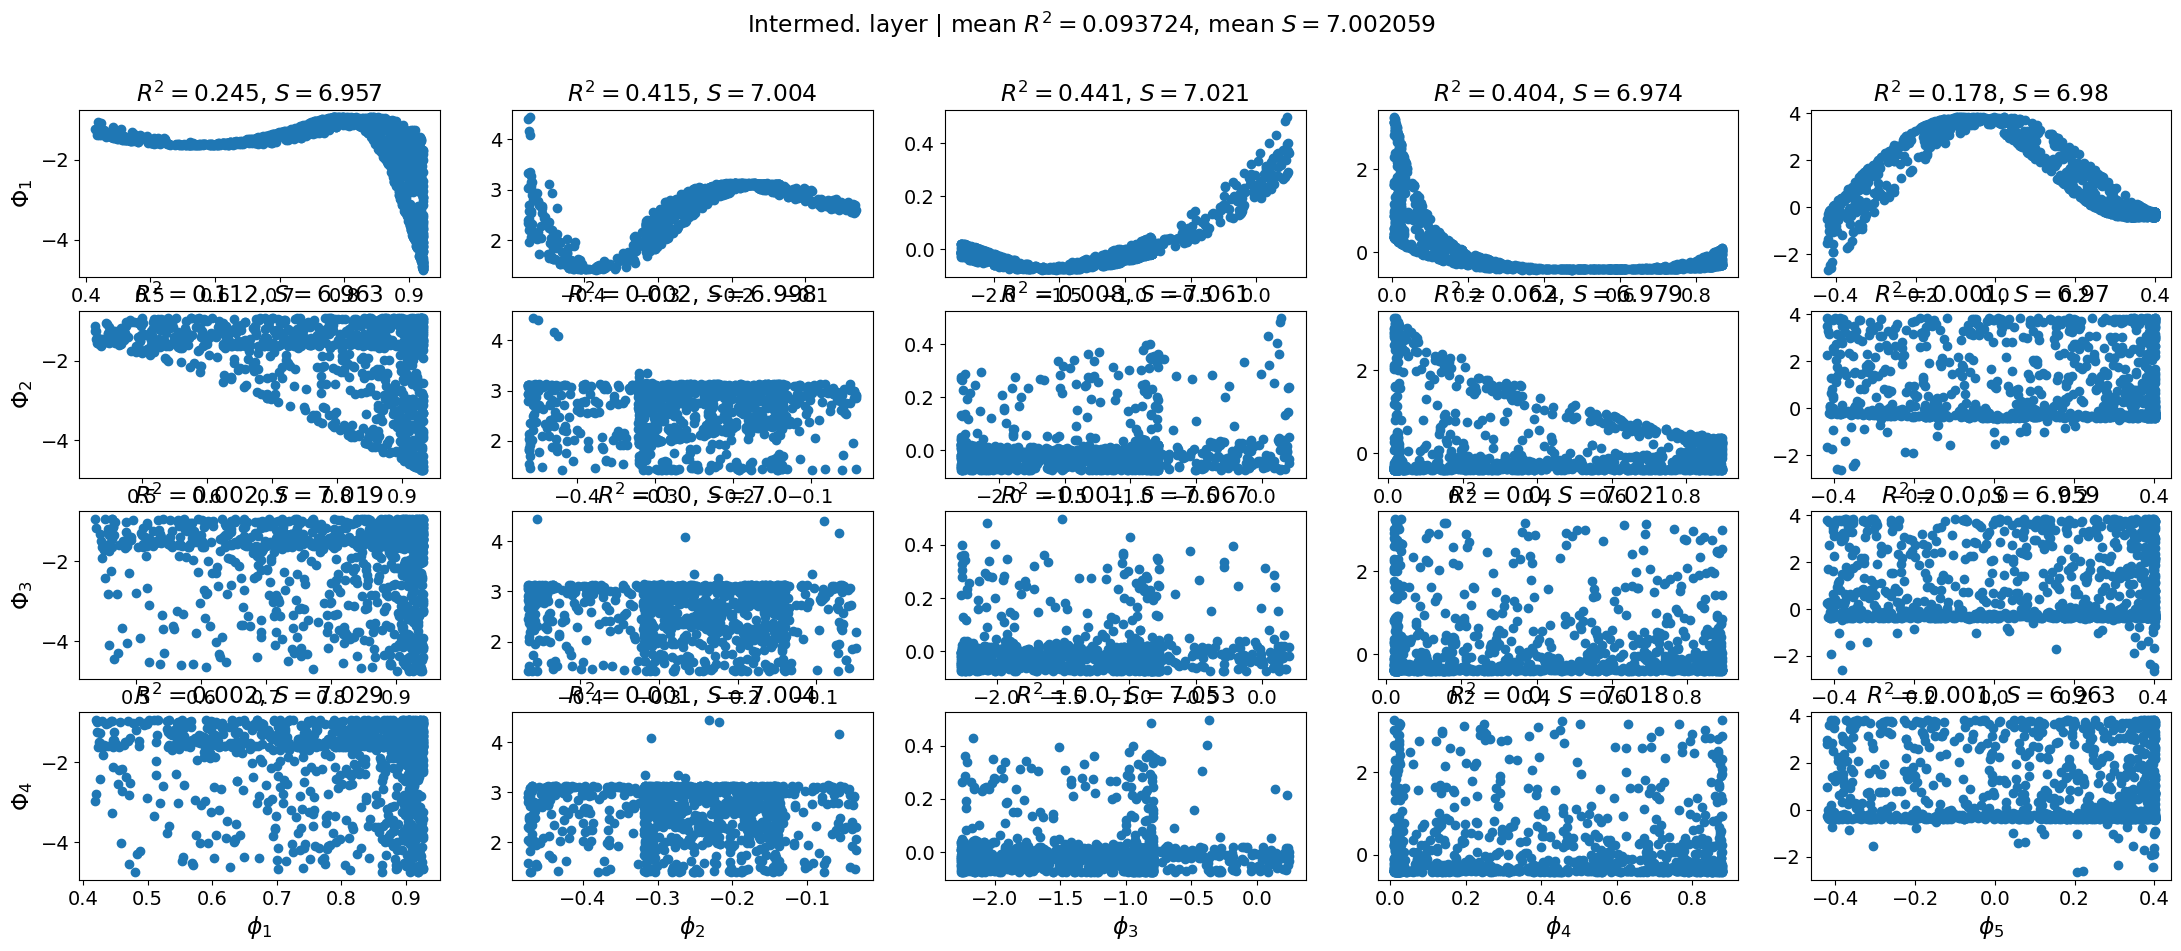

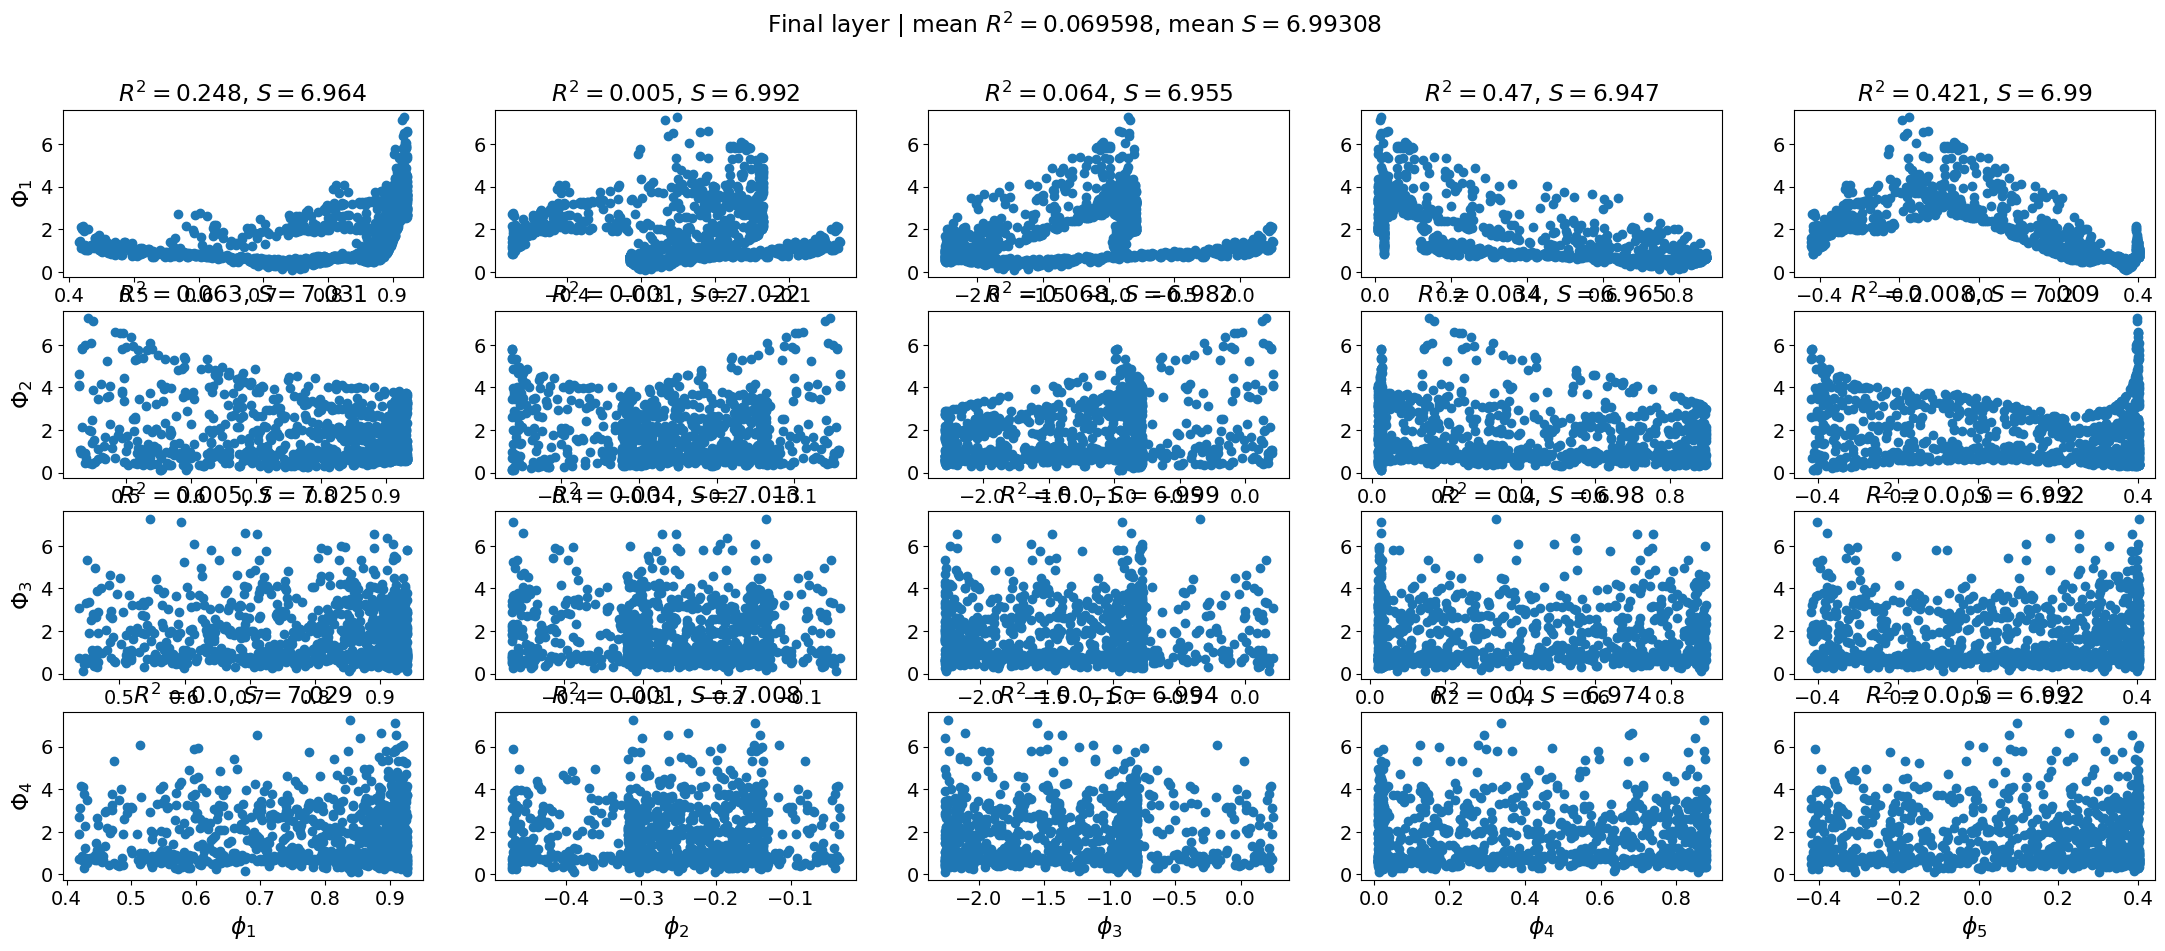

{'mean_r2': 0.06959810699449917, 'mean_matrix_entropy': 6.993080139160156}

In [26]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_1$ with __R2 regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.56e-01 | test_loss: 2.83e-01 | reg: 1.87e+01 | : 100%|█| 150/150 [03:12<00:00,  1.28


saving model version 0.1


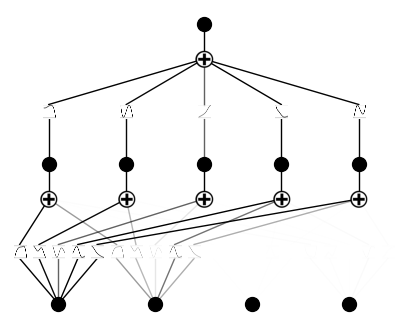

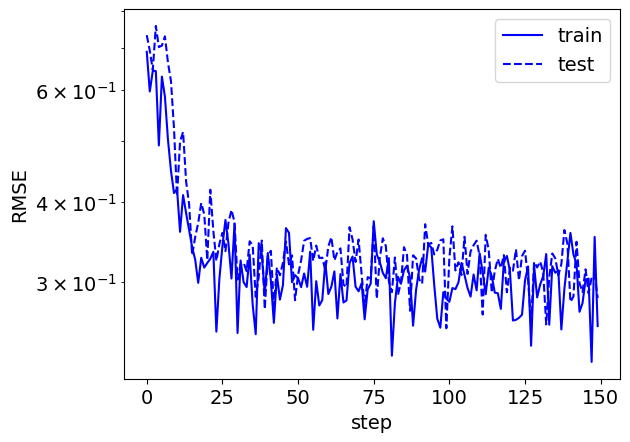

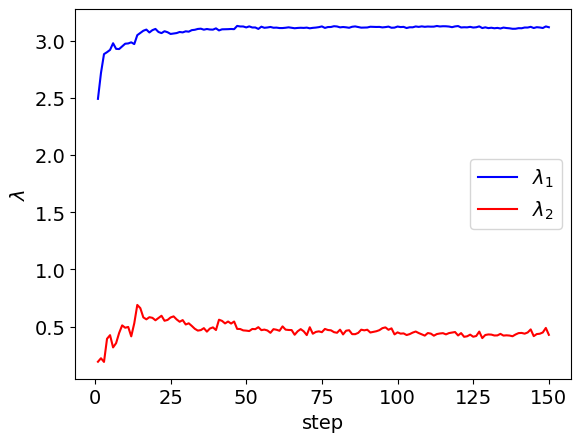

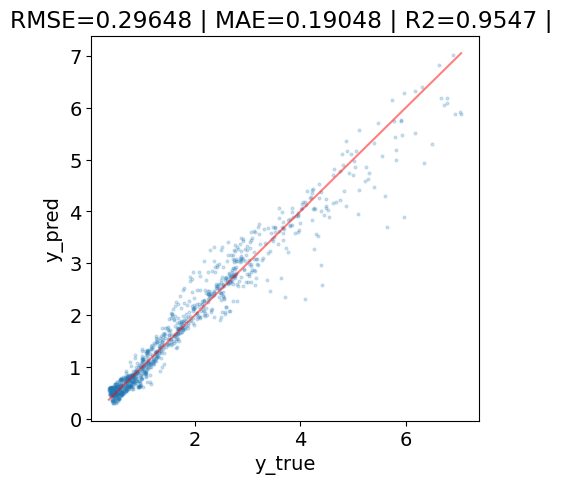

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.1170e+00,  4.2841e-01,  2.8170e-03, -1.4018e-02],
       requires_grad=True)


In [30]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:50, 15.58it/s]                         


module of Input importance:


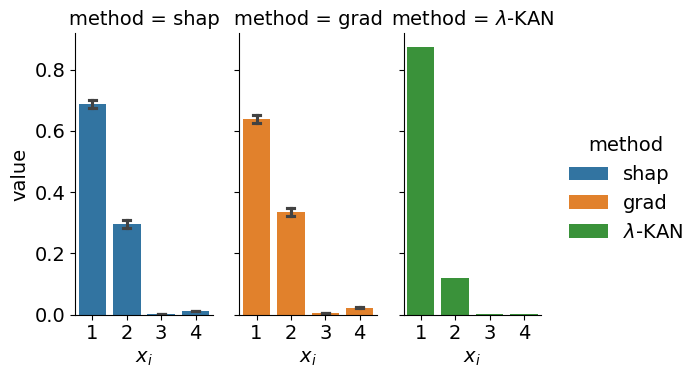

Input importance:


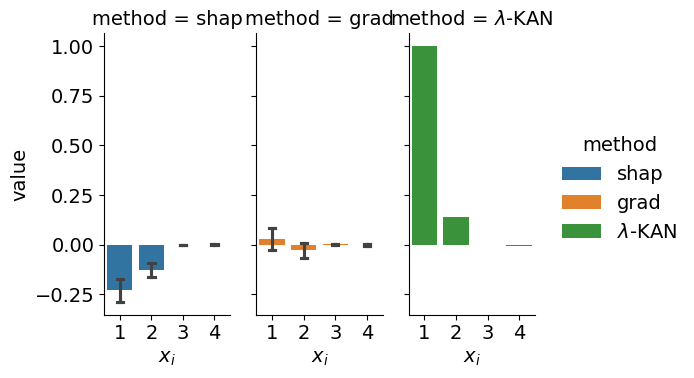

In [31]:
importance_analyse_lmdKAN(model, dataset)

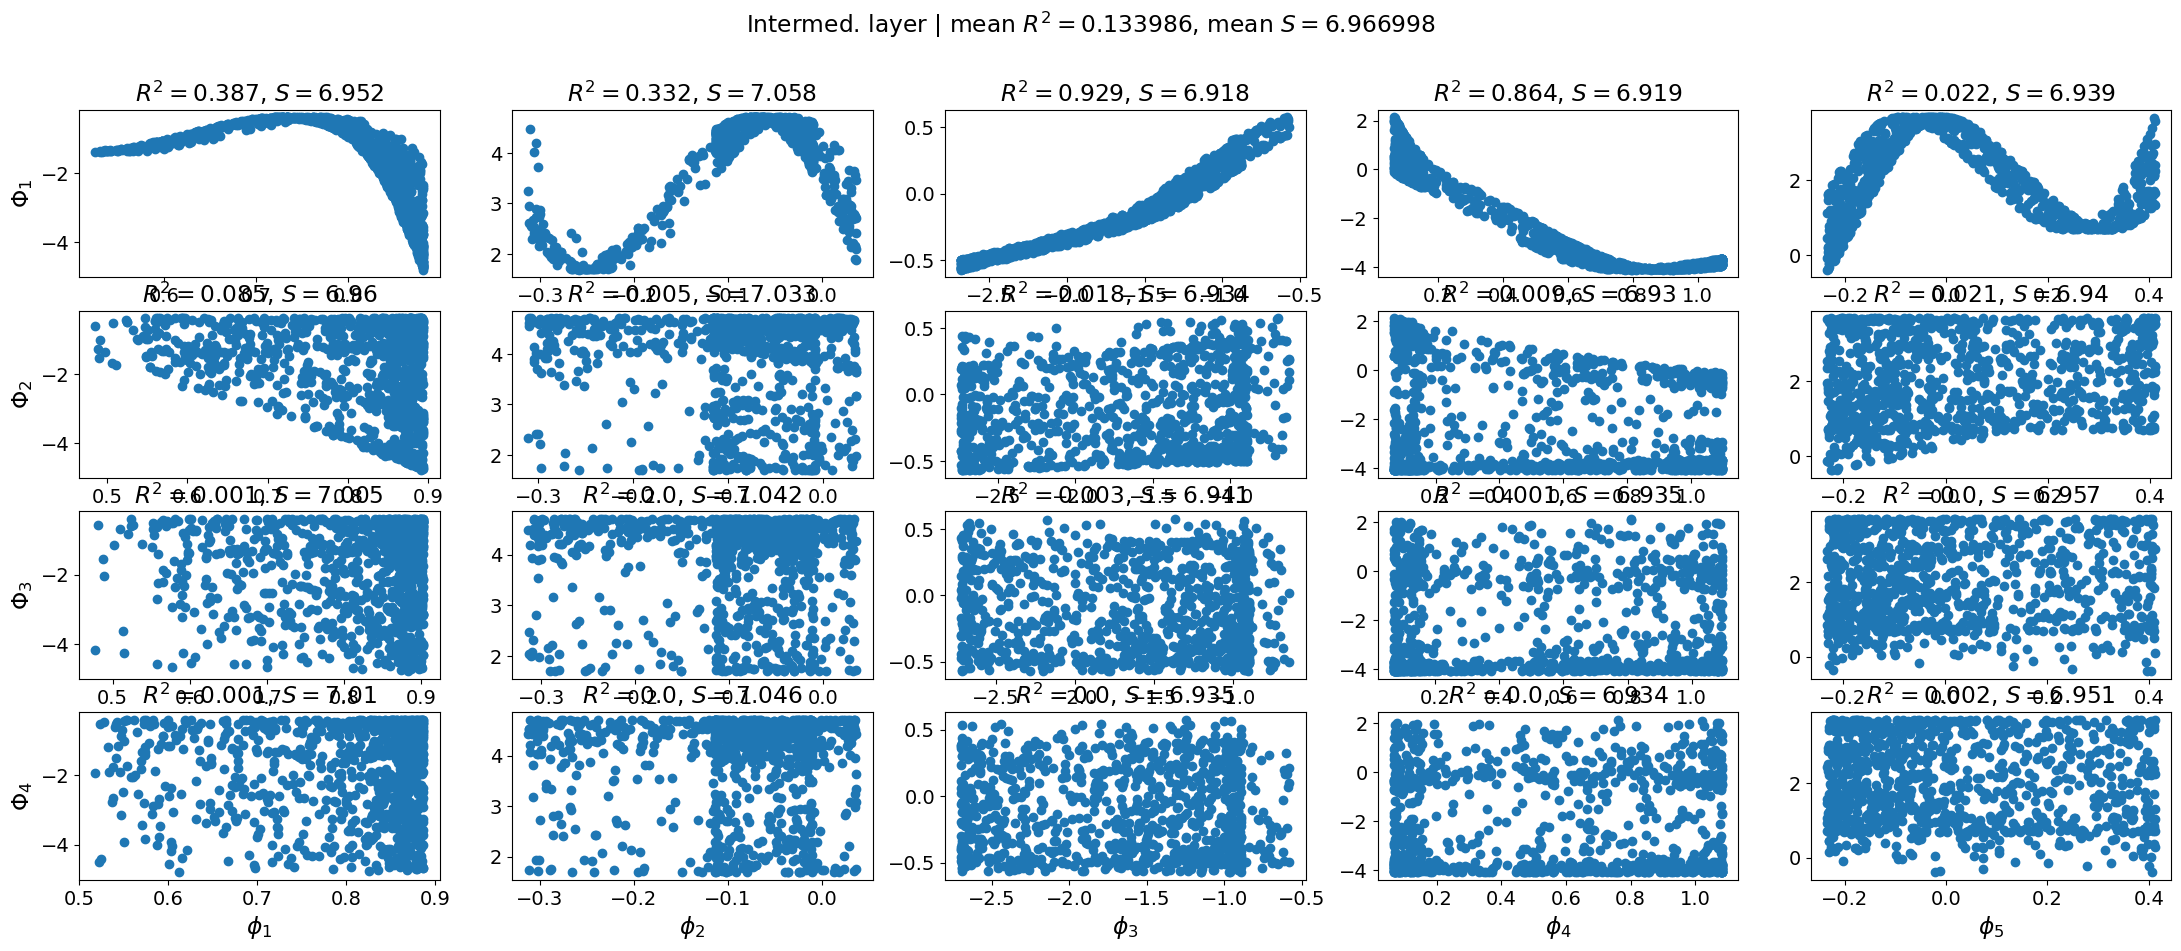

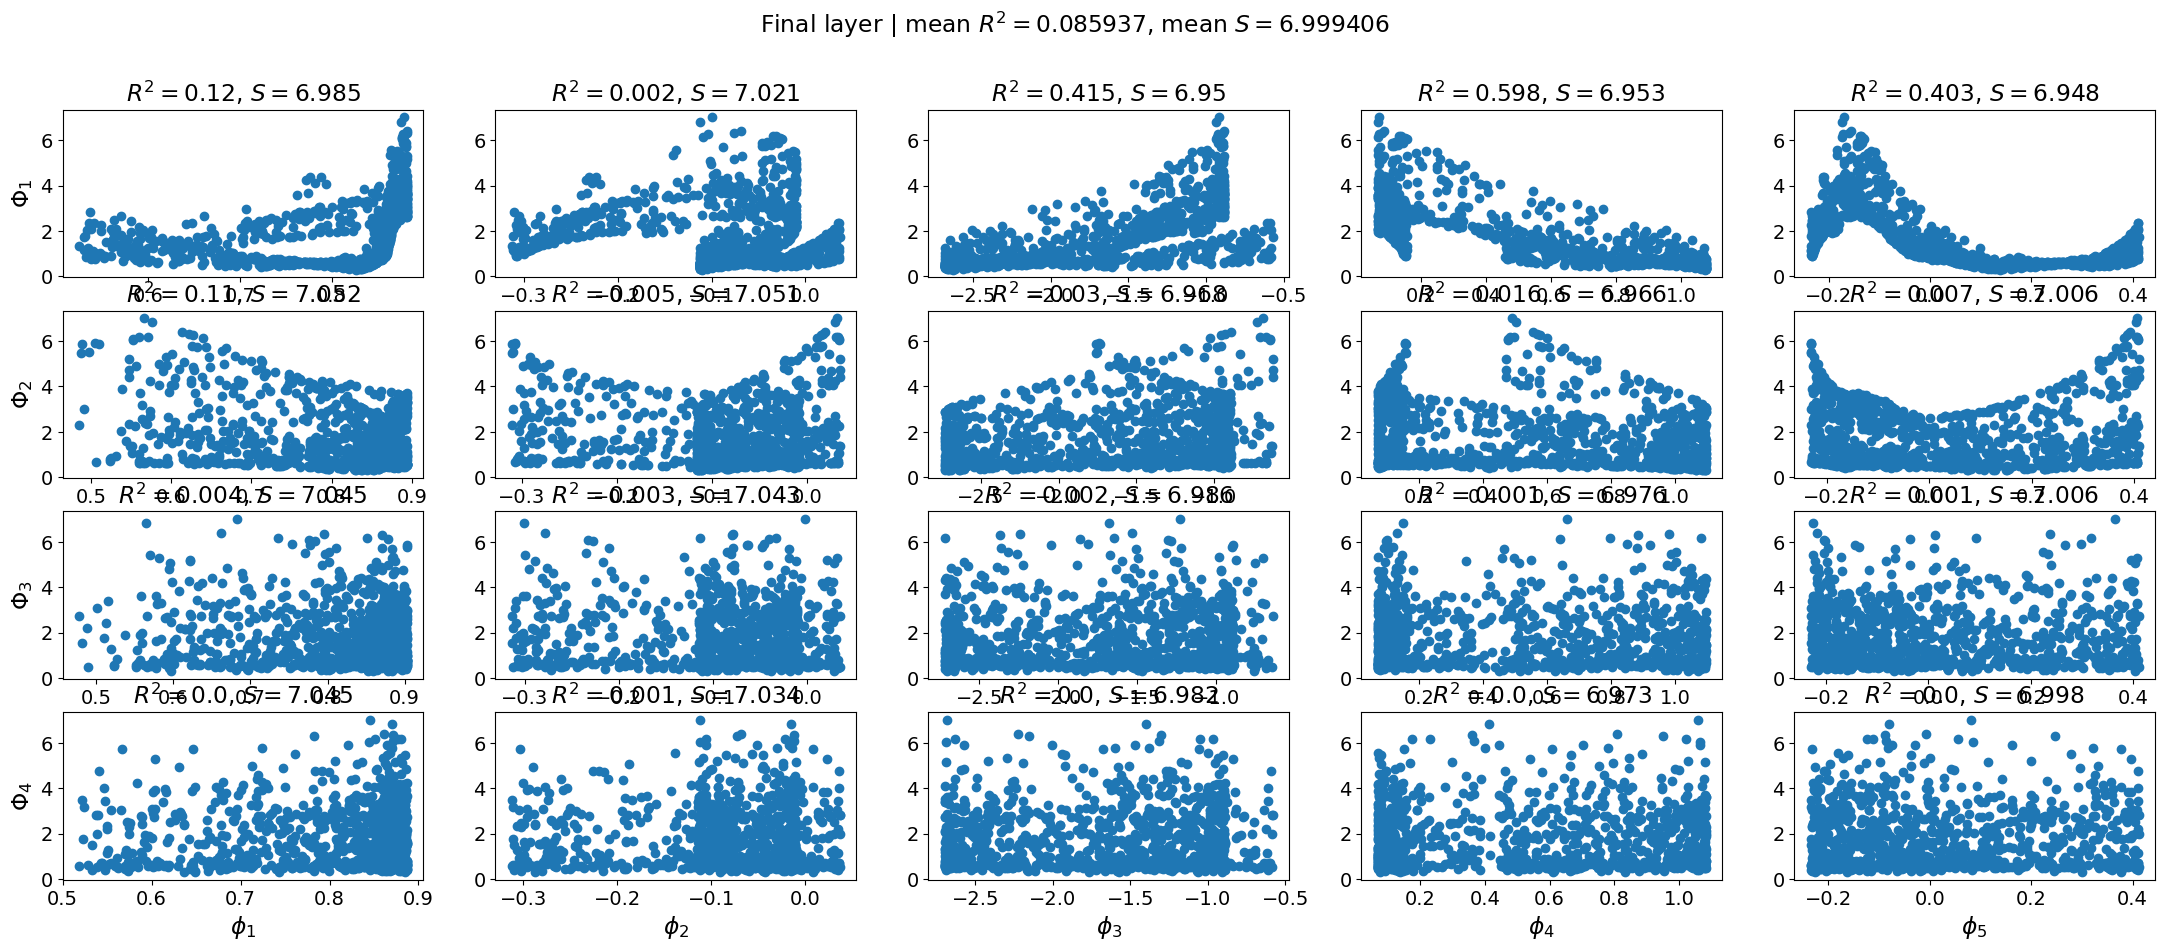

{'mean_r2': 0.08593676798464003, 'mean_matrix_entropy': 6.999406337738037}

In [32]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_1$ with __Entropy regression__ in respect to __Interm. activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.68e-01 | test_loss: 3.06e-01 | reg: 2.56e+01 | : 100%|█| 150/150 [03:27<00:00,  1.38


saving model version 0.1


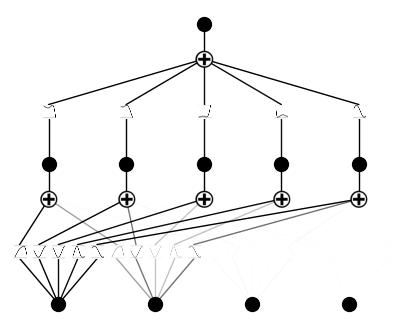

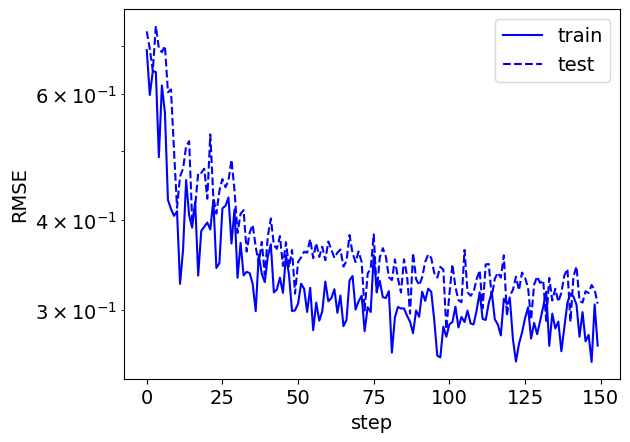

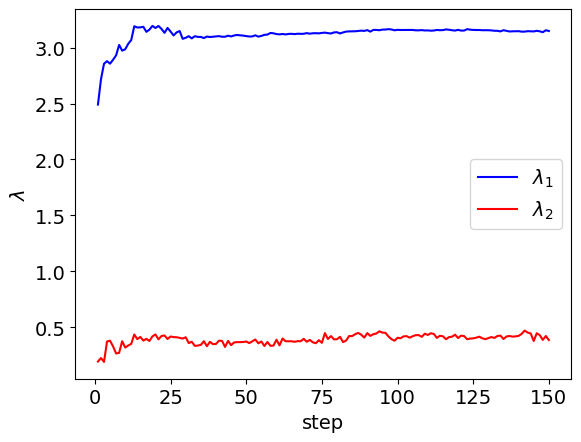

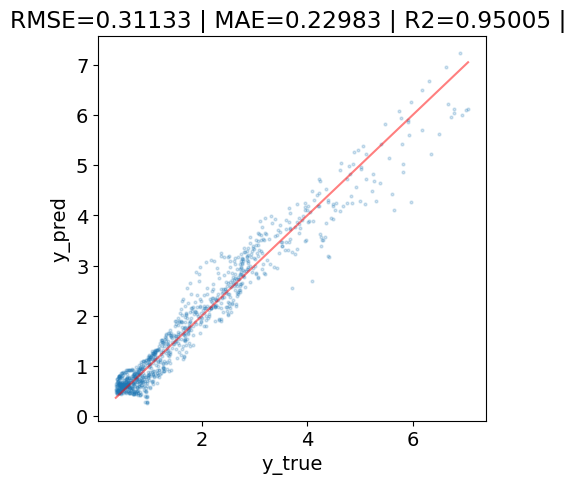

model.act_fun[0].lmd=Parameter containing:
tensor([ 3.1490,  0.3855,  0.0147, -0.0049], requires_grad=True)


In [34]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=1.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:43, 17.33it/s]                         


module of Input importance:


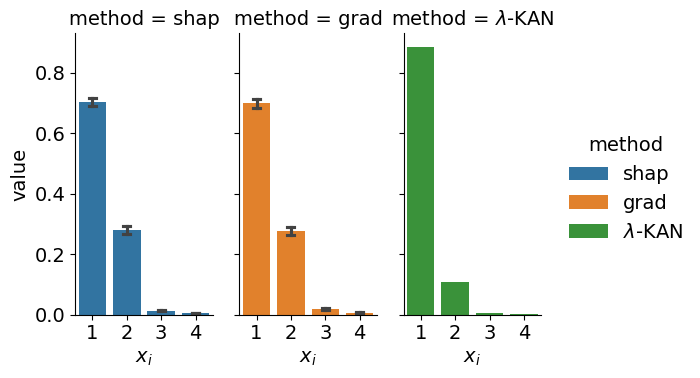

Input importance:


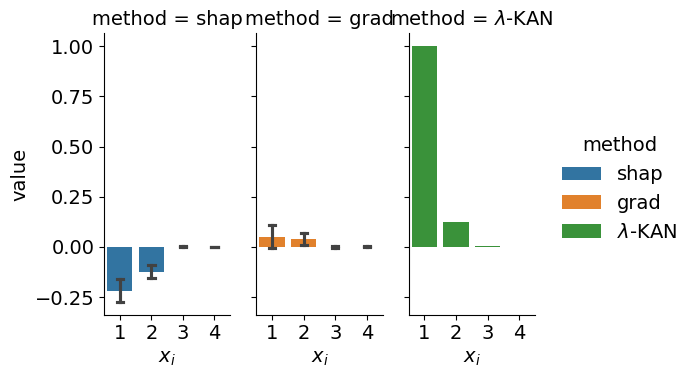

In [35]:
importance_analyse_lmdKAN(model, dataset)

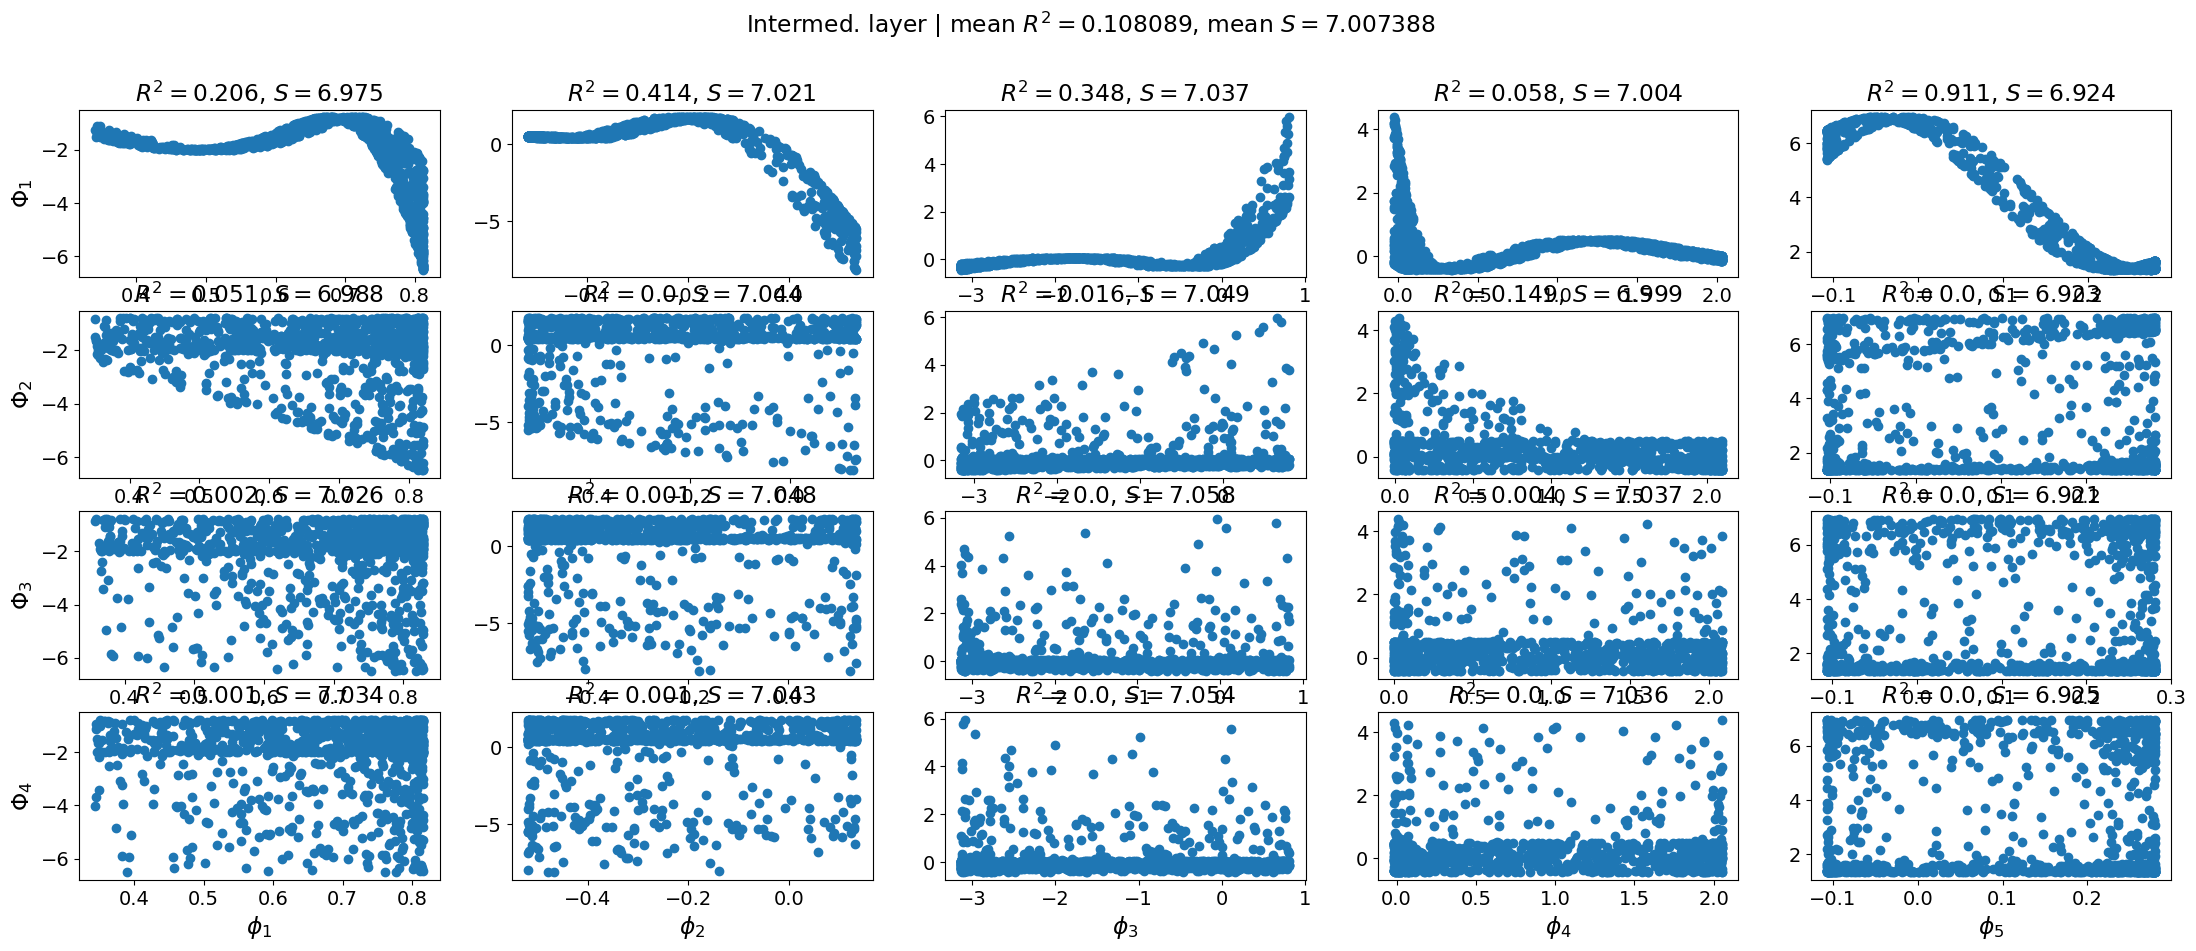

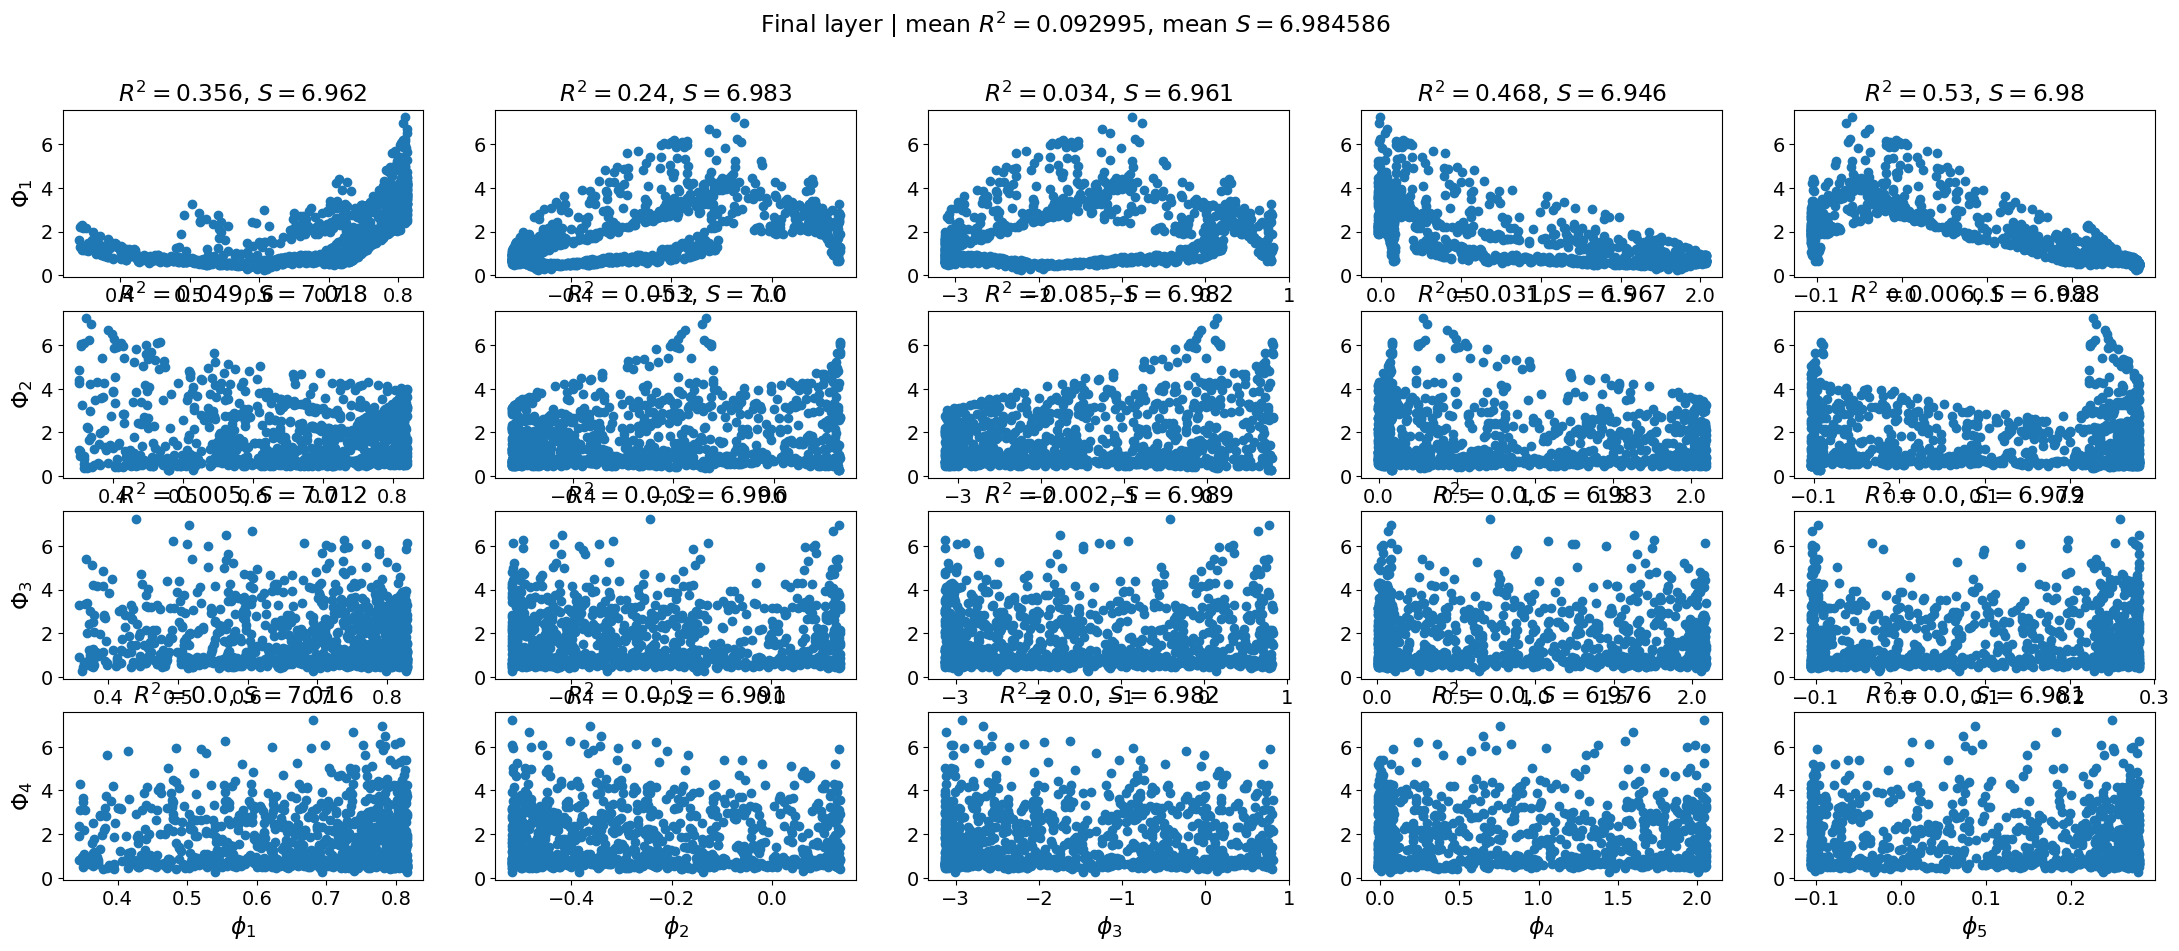

{'mean_r2': 0.09299451067636255, 'mean_matrix_entropy': 6.984585762023926}

In [36]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
-----
### $\lambda$-KAN on $f_1$ with __R2 regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


| train_loss: 2.94e-01 | test_loss: 3.06e-01 | reg: 2.38e+01 | : 100%|█| 150/150 [05:44<00:00,  2.30


saving model version 0.1


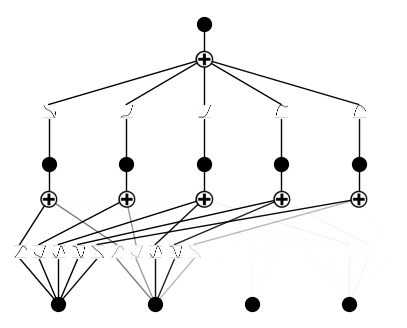

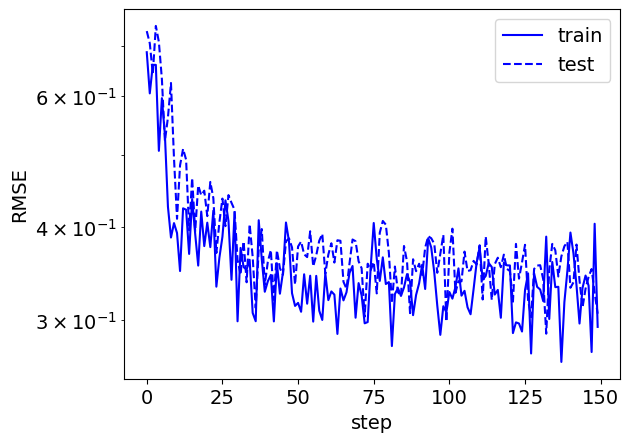

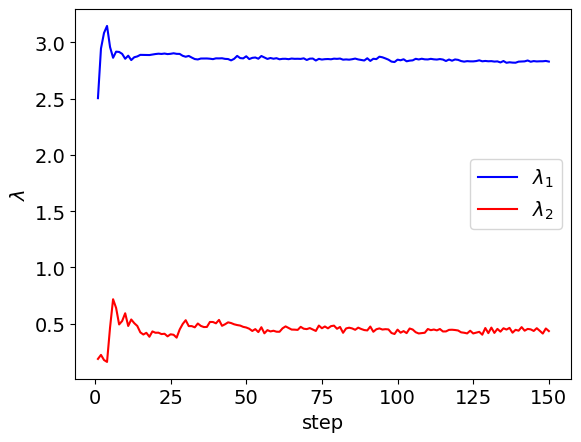

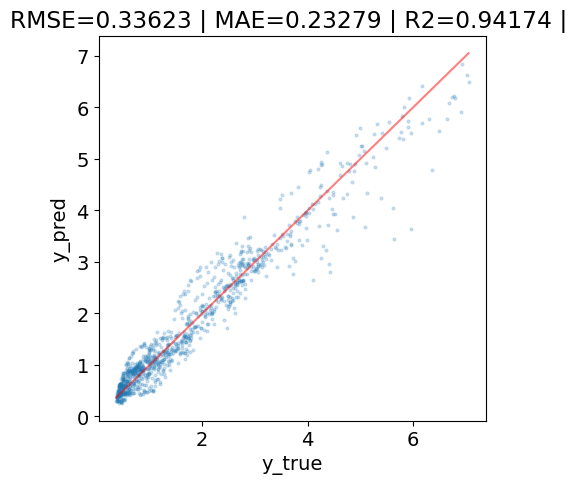

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.8293,  0.4343, -0.0041, -0.0113], requires_grad=True)


In [37]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='r2',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:51, 16.07it/s]                         


module of Input importance:


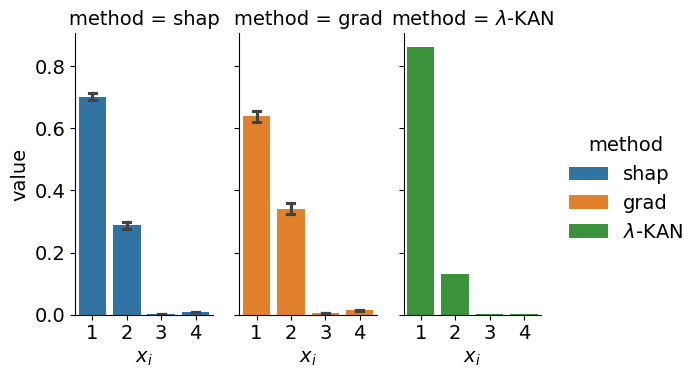

Input importance:


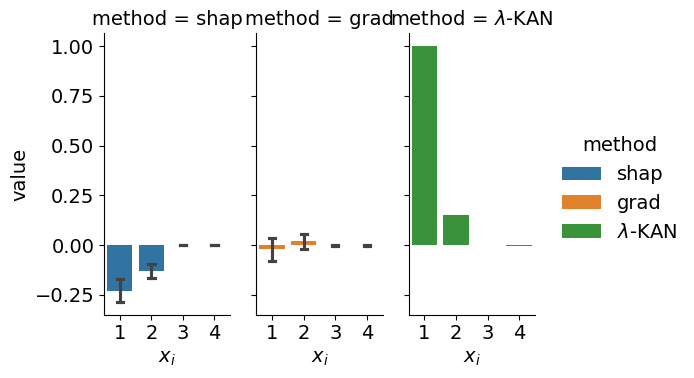

In [38]:
importance_analyse_lmdKAN(model, dataset)

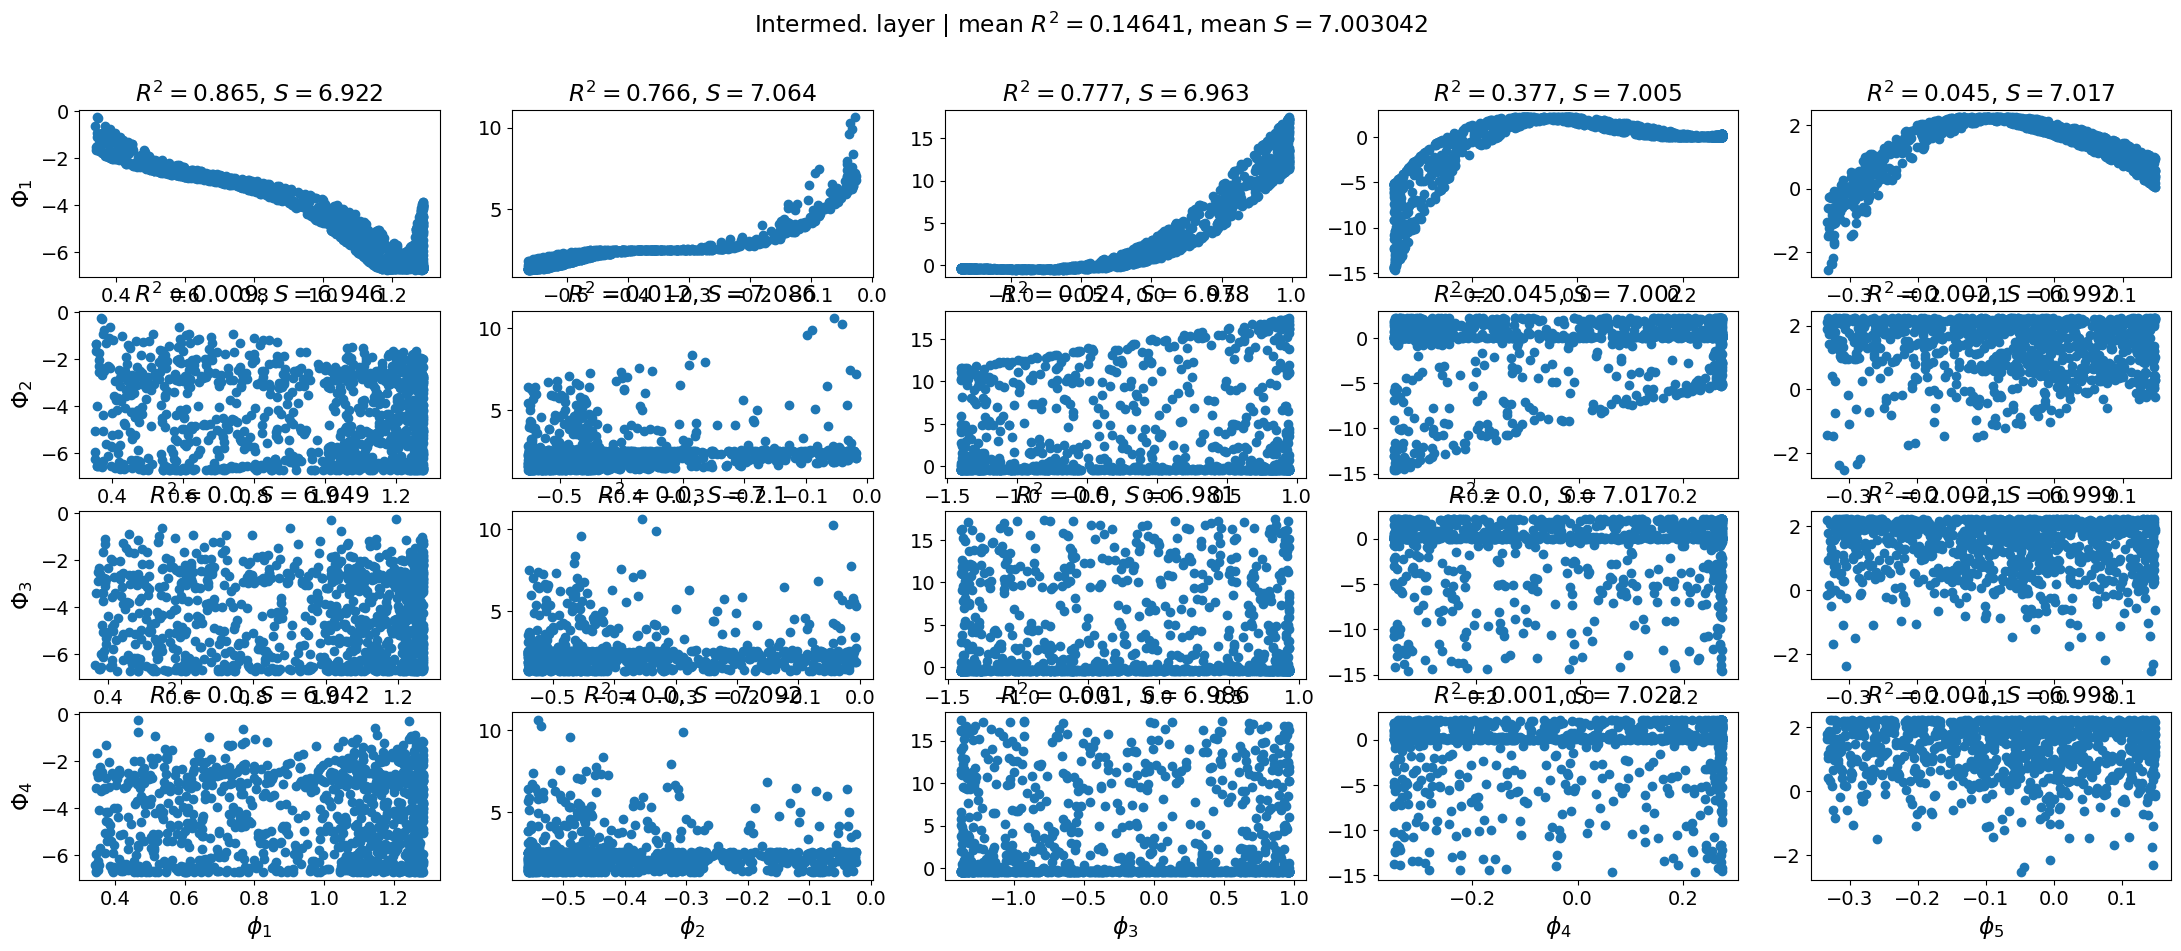

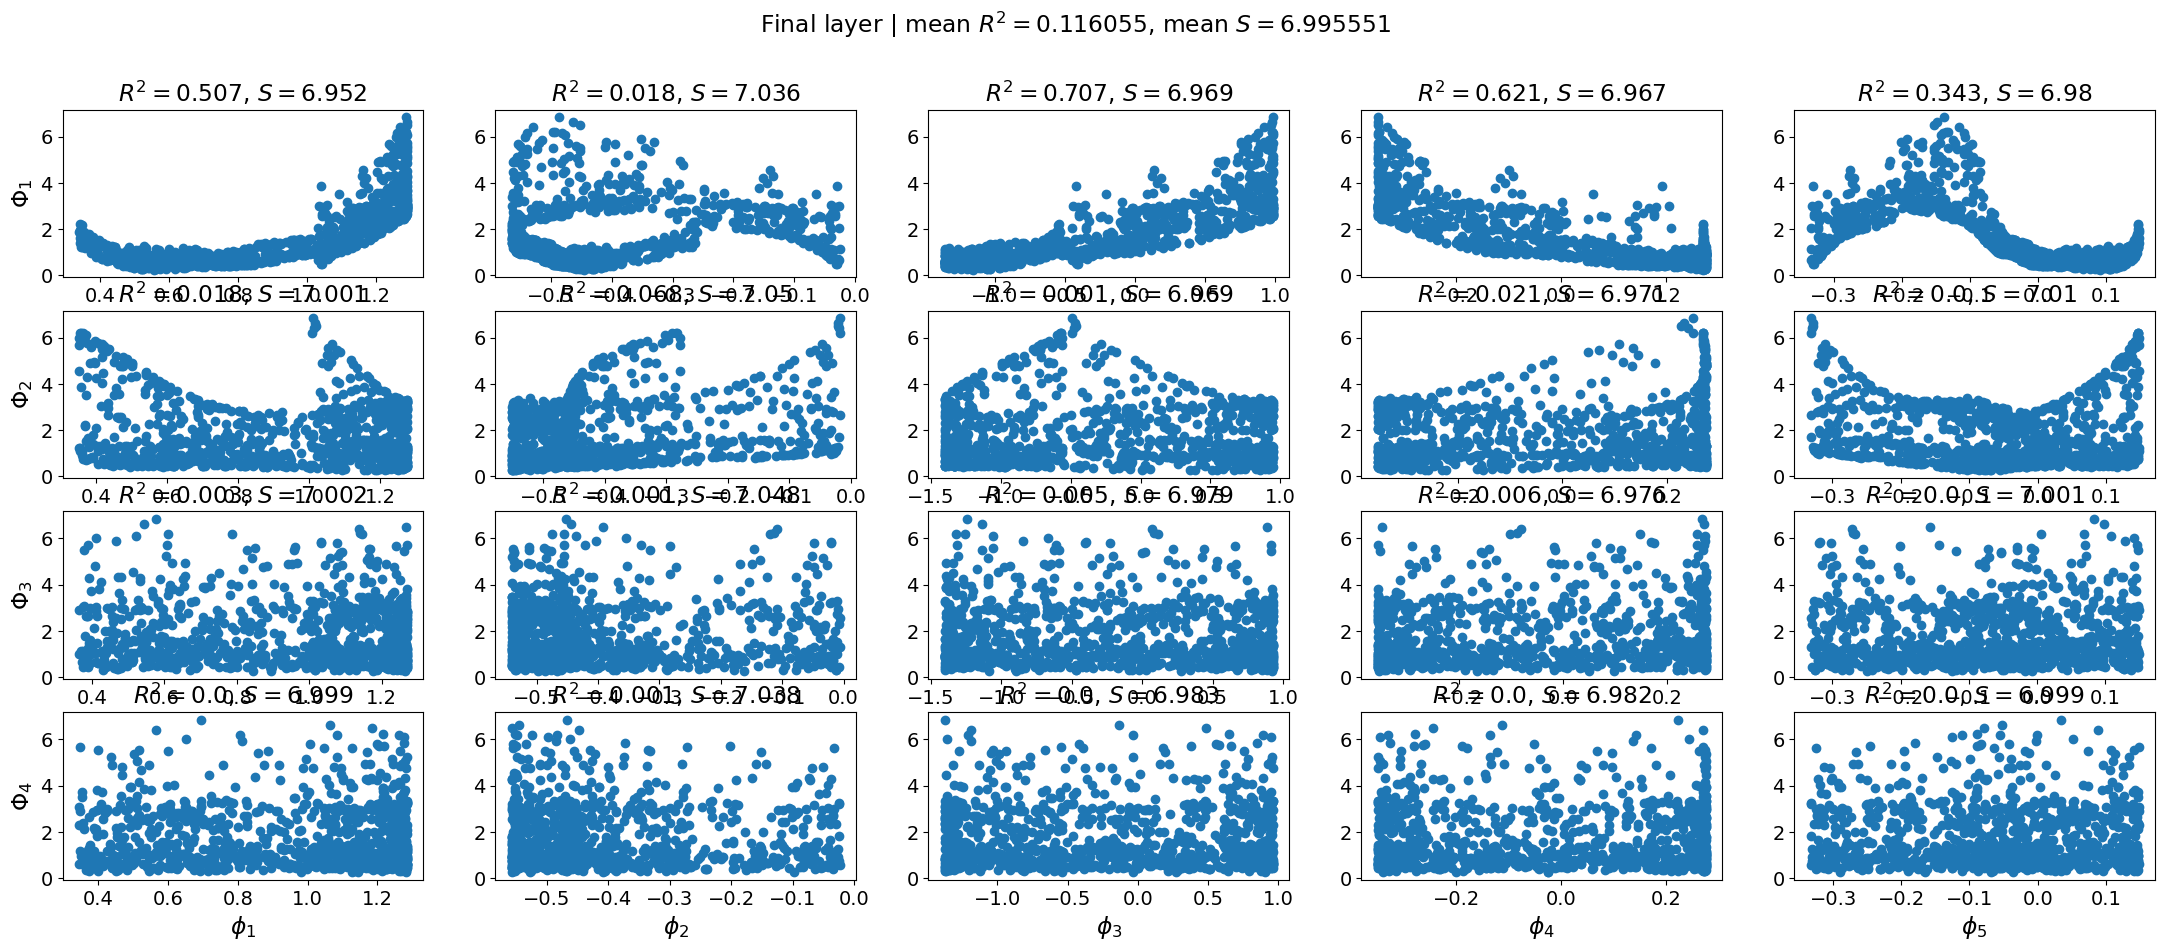

{'mean_r2': 0.11605453084466717, 'mean_matrix_entropy': 6.995551109313965}

In [39]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')

-----
### $\lambda$-KAN on $f_1$ with __Entropy regression__ in respect to __Final activations__

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.93e-01 | test_loss: 3.04e-01 | reg: 2.39e+01 | : 100%|█| 150/150 [01:32<00:00,  1.62


saving model version 0.1


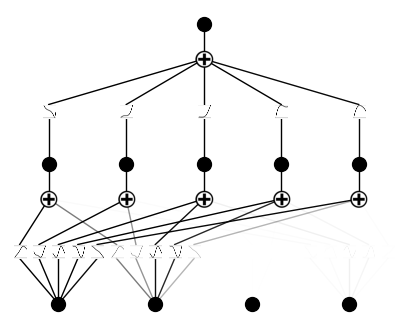

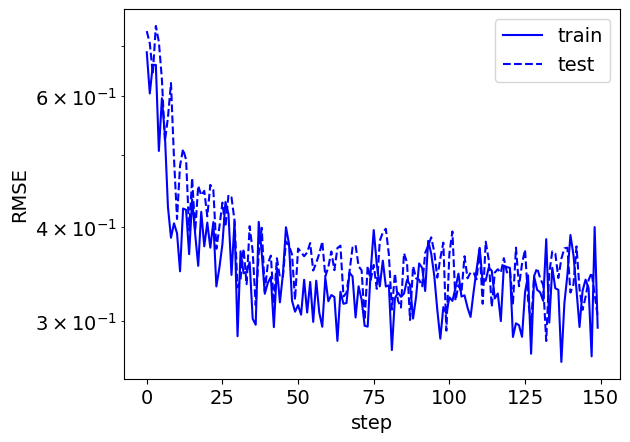

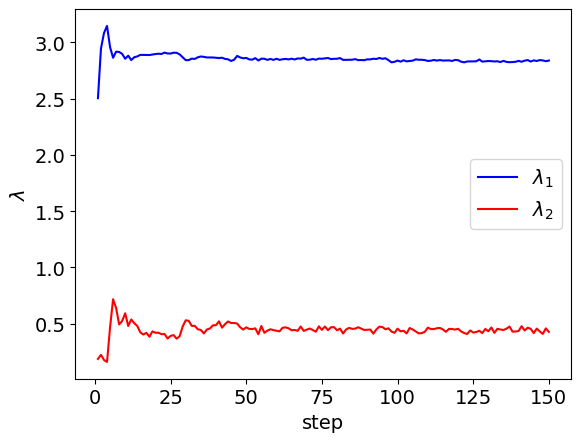

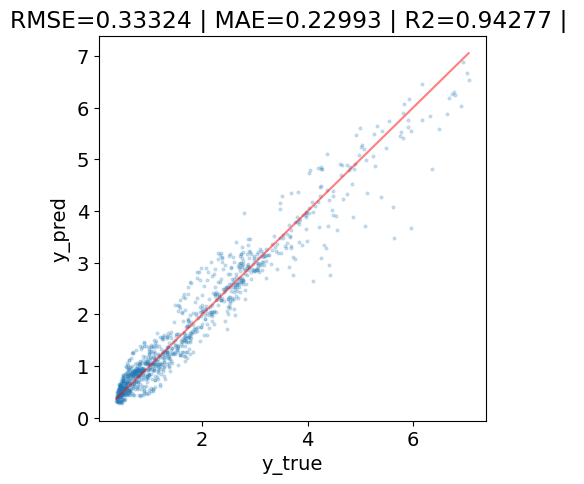

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.8384e+00,  4.2700e-01,  8.6307e-04, -1.4353e-02],
       requires_grad=True)


In [41]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=1.0, reg_type='entropy',
                    batch=250)

kan_summary_after_fit(model, dataset, results, lmdKAN=True)

model.forward(dataset['test_input'])

print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:26, 23.41it/s]                          


module of Input importance:


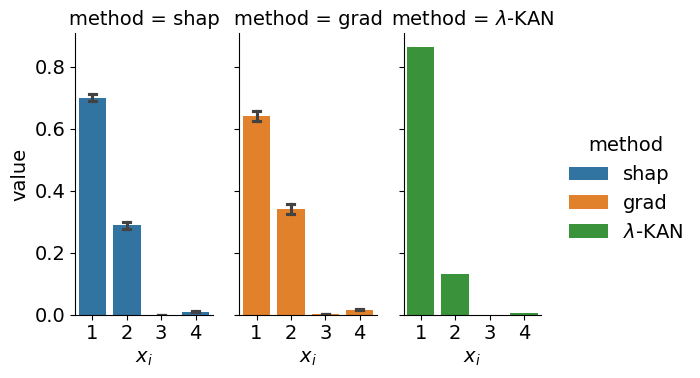

Input importance:


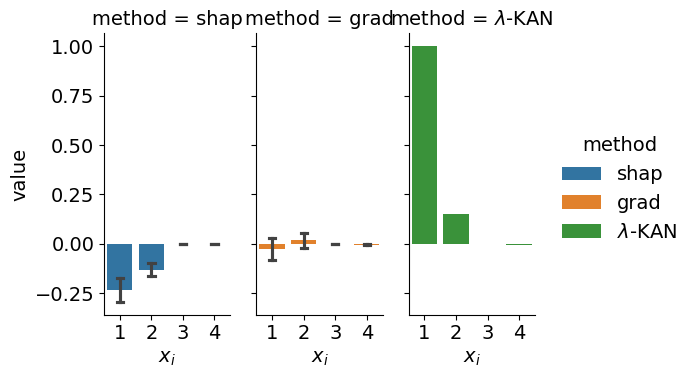

In [42]:
importance_analyse_lmdKAN(model, dataset)

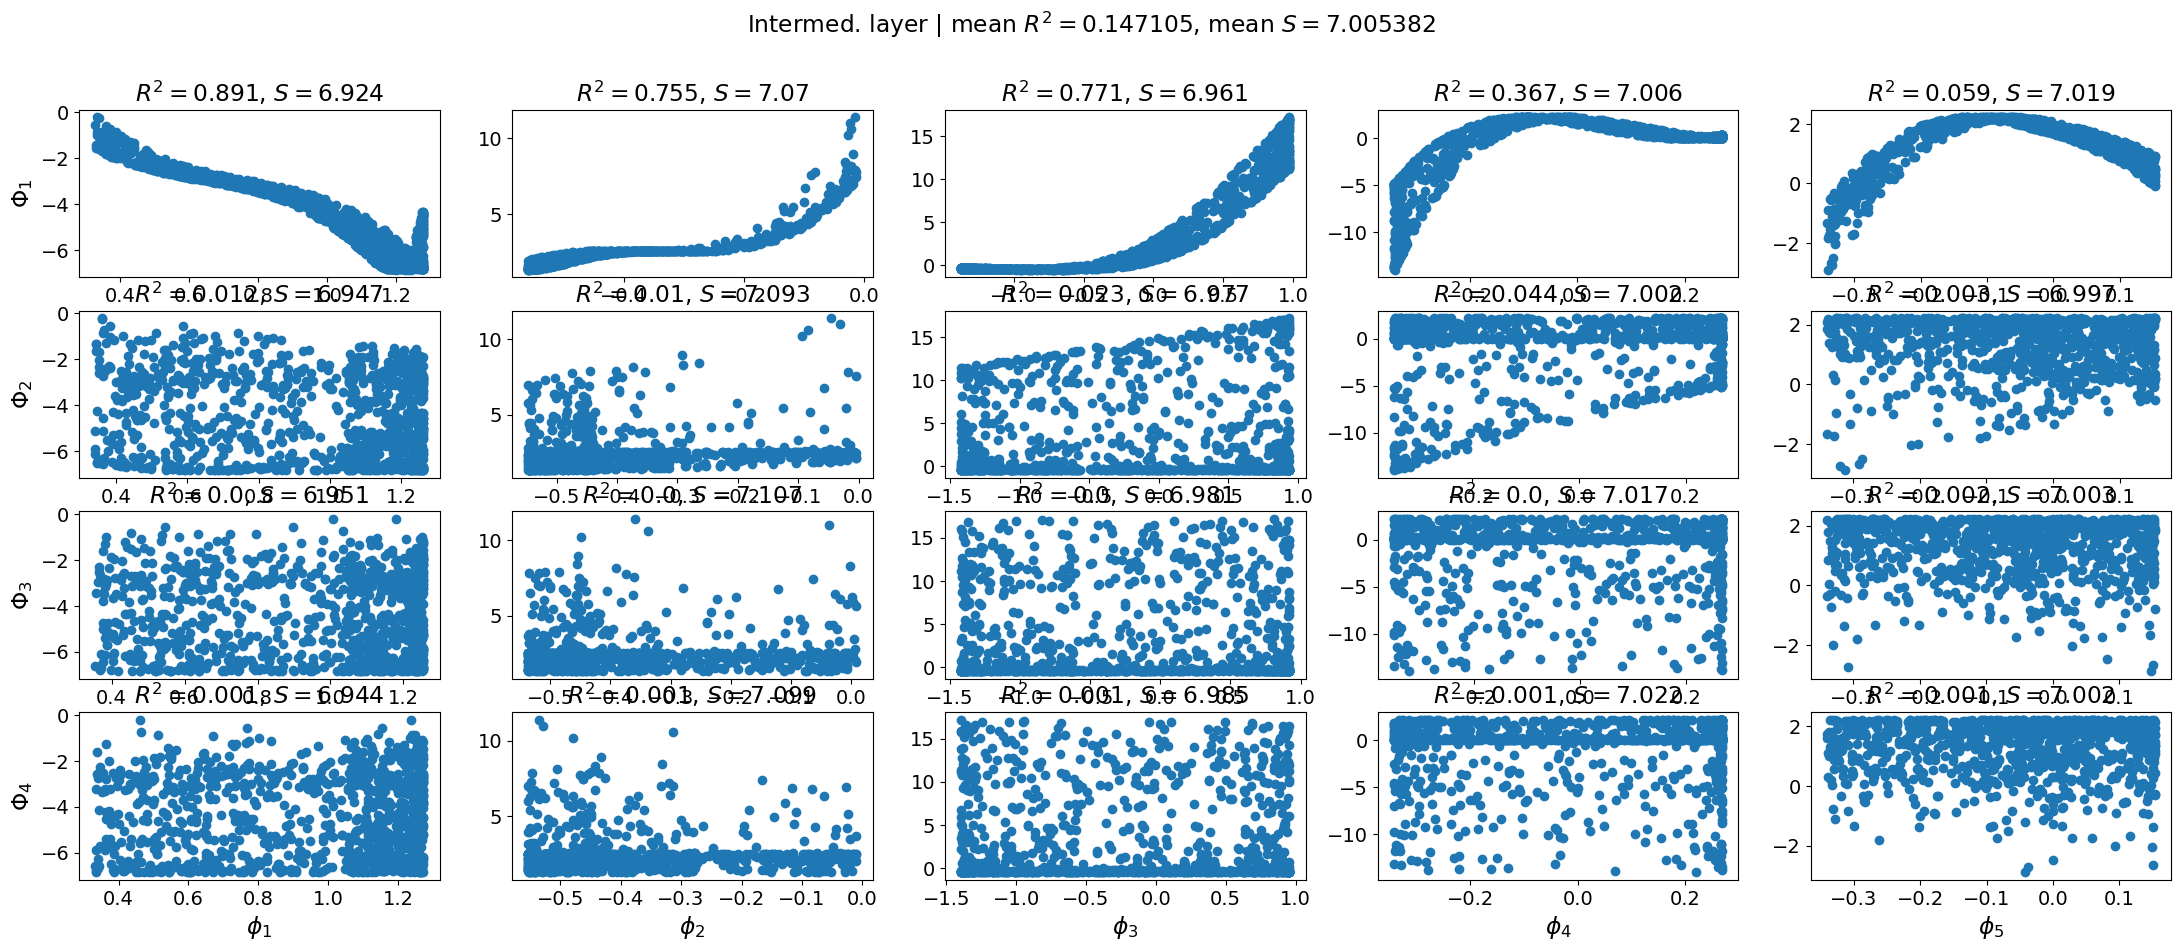

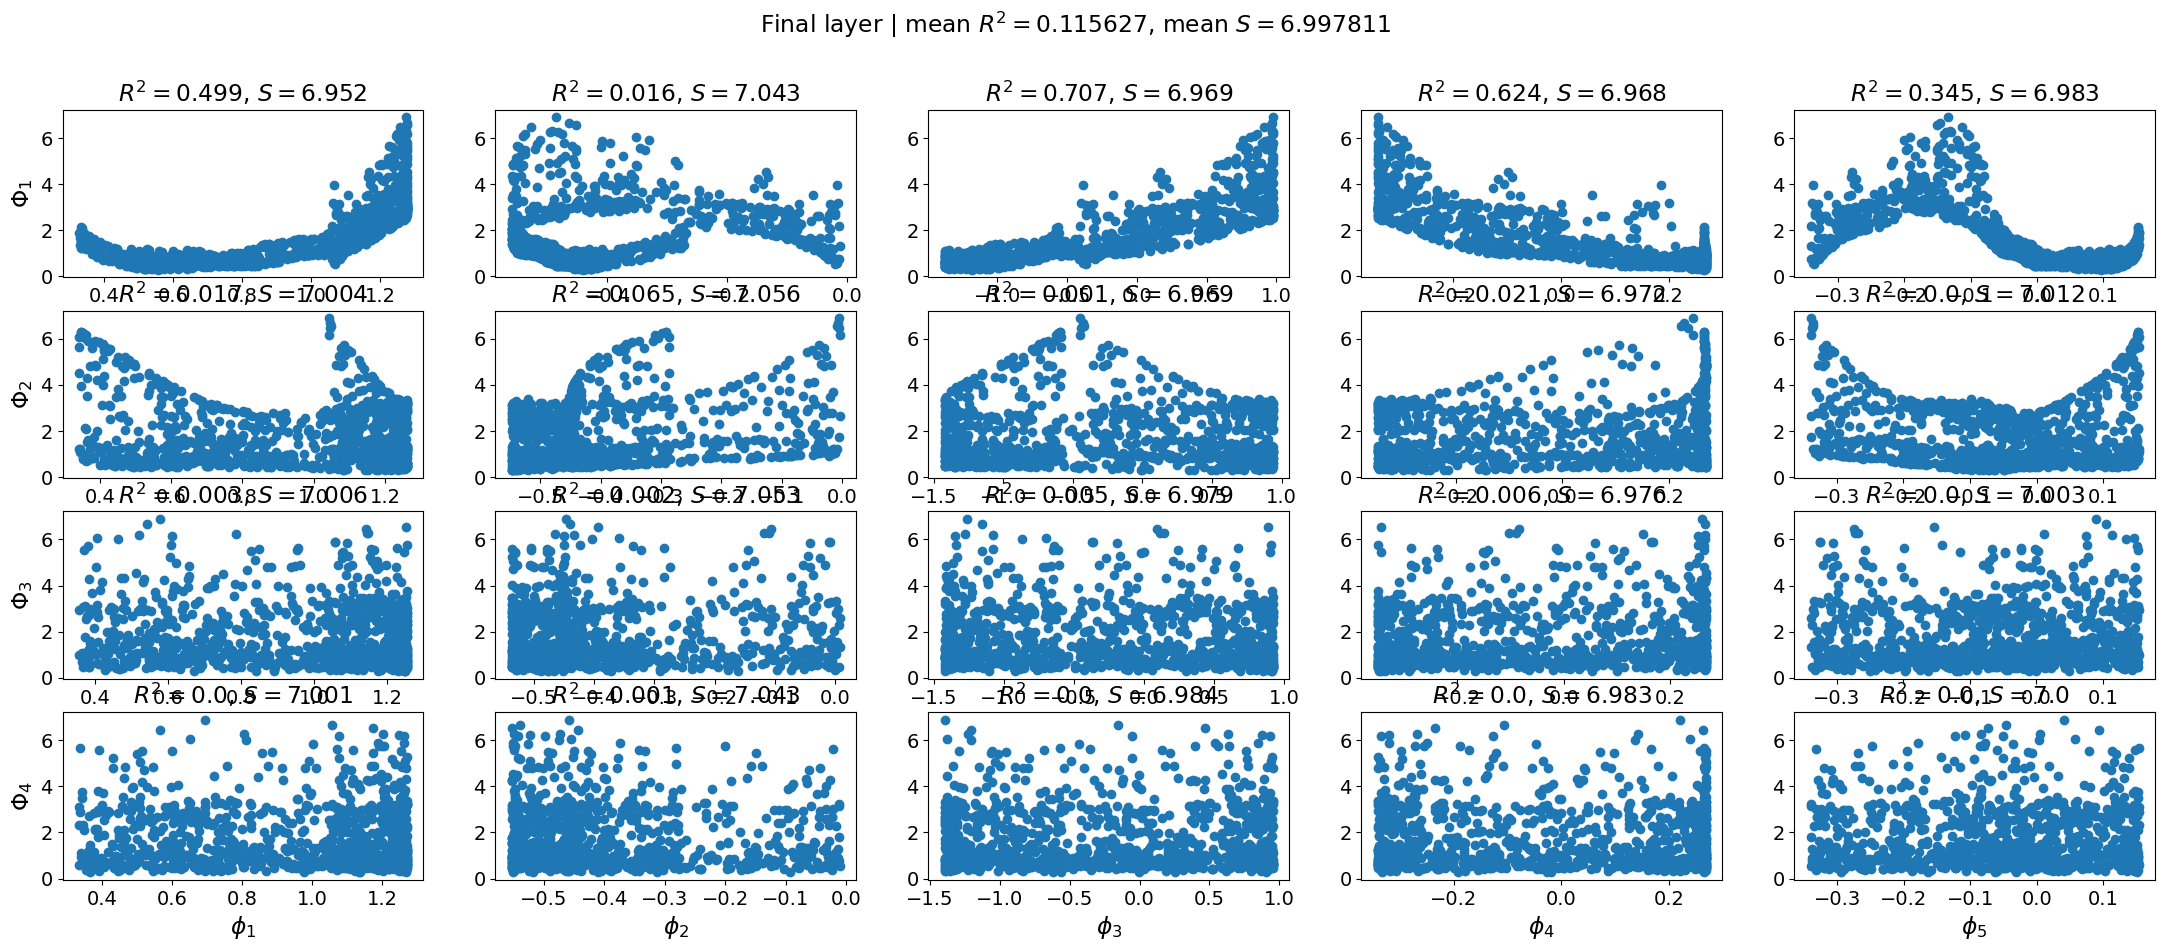

{'mean_r2': 0.115627110006335, 'mean_matrix_entropy': 6.997811317443848}

In [43]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')